R-CNN  
1. Input image  
\- Fast R-CNN: 관심영역을 고정시킴
2. Extract region proposals  
3. Compute CNN features -> 전이학습  
4. Classify regions
  
Faster R-CNN  
1. 합성곱 신경망층 처리  
2. 객체를 감지할 수 있는 마스크 생성  
3. 객체 감지 후 분류  

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 17.11 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [ ]:
%cd Mask_RCNN/

/content/Mask_RCNN


In [ ]:
!python setup.py install

In [ ]:
%cd ..

/content


In [ ]:
import os
import sys
import cv2
import numpy as np
import skimage.io

In [ ]:
#%tensorflow_version 1.x
#import tensorflow as tf
import tensorflow.compat.v1 as tf

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
ROOT_DIR = os.path.abspath('./Mask_RCNN/')

In [ ]:
sys.path.append(ROOT_DIR)

In [ ]:
sys.path.append(os.path.join(ROOT_DIR, 'sample/coco'))

In [ ]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')

In [ ]:
MODEL_DIR, IMAGE_DIR

('/content/Mask_RCNN/logs', '/content/Mask_RCNN/images')

In [ ]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')
utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
class InferenceConfig(coco.CocoConfig):
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

In [ ]:
config = InferenceConfig()
network = modellib.MaskRCNN(model='inference', model_dir=MODEL_DIR, config=config)
network.load_weights(COCO_MODEL_PATH, by_name=True)

In [ ]:
image = skimage.io.imread('/content/Mask_RCNN/images/2516944023_d00345997d_z.jpg')

In [ ]:
results = network.detect([image], verbose=0)
results

In [ ]:
visualize.display_instances(image, result['rois'], result['mask'], result['class_ids'], class_names, result['scores'])


In [ ]:
np.unique(r['masks'], return_counts=True)

def segment(image, r, index):
  mask = r['mask'][:,:,index]
  mask = np.stack((mask,)*3,axis=1)
  mask = mask.astype('uint8')
  bg = 255-mask*255
  mask_show = np.invert(bg)
  mask_img = image*mask
  result = mask_img+bg
  return result, mask_show


def show_segment(image, r, index, show_mask = False):
  segmentation, mask_obj = segment(image, r, index)
  plt.subplots(1,figsize=(16,16))
  plt.axis('off')
  if show_mask == True:
    plt.imshow(np.concatenate([mask_obj, segmentation], axis=1))
  else:
    plt.imshow(np.concatenate([image, segmentation], axis=1))

for index in range(len(r['rois'])):
  show_segment(image,r,index,False)


capture = cv2.VideoCapture("video_street2.mp4")
connectd, frame = capture.read()
save_video = cv2.VideoWriter("result_video.mp4", cv2,VideoWriter_fourcc(*XVID), 24, (frame.shape[1]))

from mrcnn import video_functions

colors = video_functions.random_colors(len(classes_name), 55)

def show(img):
  fig = plt.gcf()
  fig.set_size_inches(16,10)
  plt.axis('off')
  plt.imshow('off')
  plt.show()

frame_show = 20
current_frame = 0

while (cv2.waitKey(1) < 0):
  connected, frame = capture.read()
  if not connected:
    break
  results = network.detect([frame], verbose=0)
  r = results[0]
  processed_frame = video_function.display_instances(frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores', colors=colors])

  if current_frame <= frames_show:
    show(processed_frame)
    current_frame += 1

  save_video.write(cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB))
save_video.release()


In [ ]:
#https://limjun92.github.io/assets/TensorFlow%202.0튜토리얼/6.%20이미지/%5B튜토리얼5%5D%20이미지%20세그멘테이션/

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
import warnings
warnings.simplefilter('ignore')

import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if display_list[i].shape[2]>1:
            plt.imshow(display_list[i])
        else:
            plt.imshow(np.array(display_list[i]).reshape(128,128))
        plt.axis('off')
    plt.show()

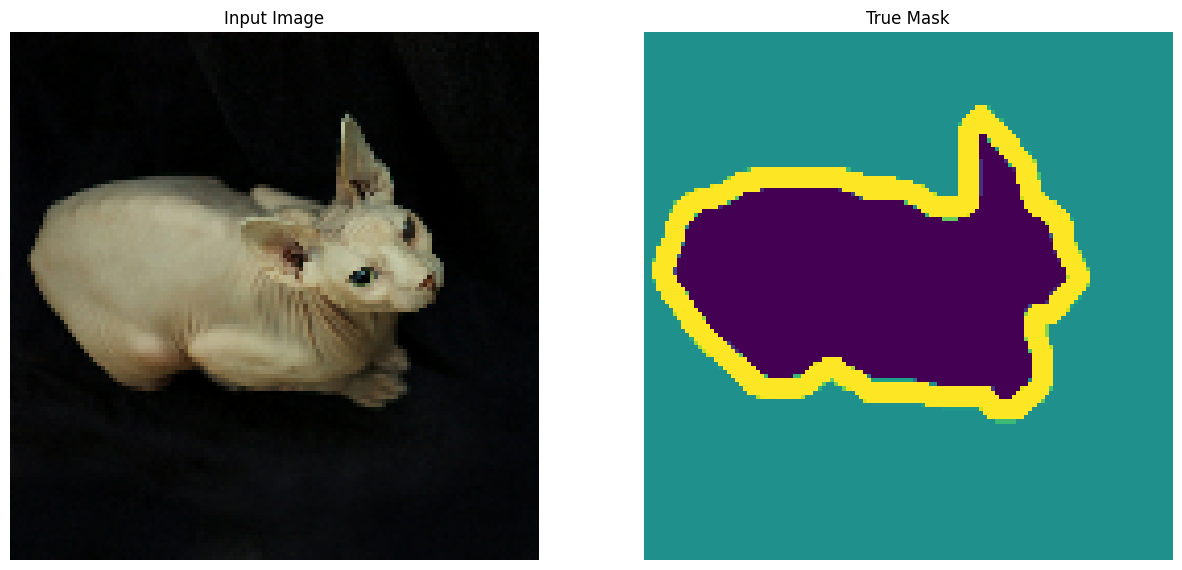

In [ ]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# 다음과 같은 레이어 활성화 함수를 사용합니다.
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 피쳐를 추출하는 모델을 생성합니다.
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):

    # 모델의 마지막 레이어입니다.
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='softmax')  #64x64 -> 128x128

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # 모델을 통해 다운샘플링합니다.
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # 업샘플링과 스킵 커넥션(skip conection)을 합니다.
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

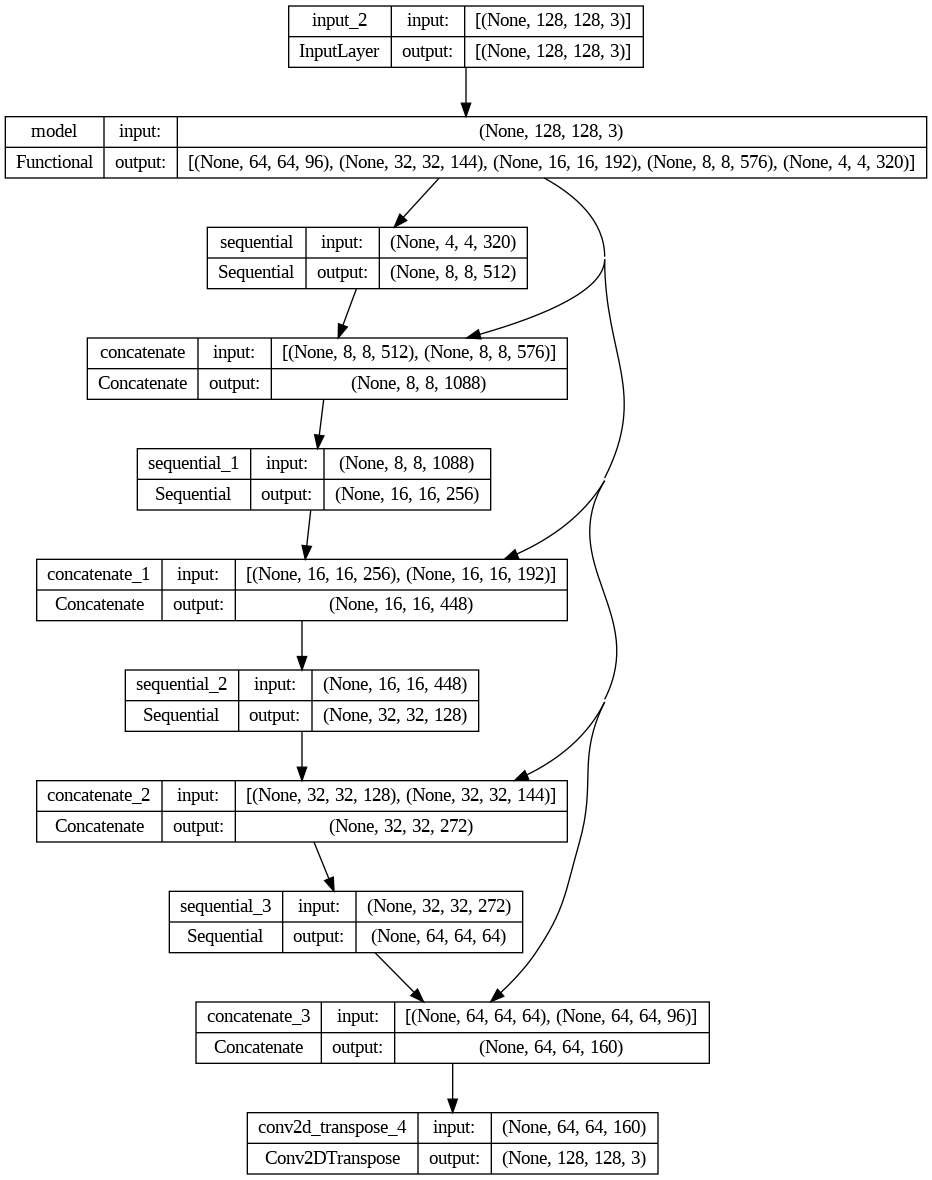

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 5s 5s/step


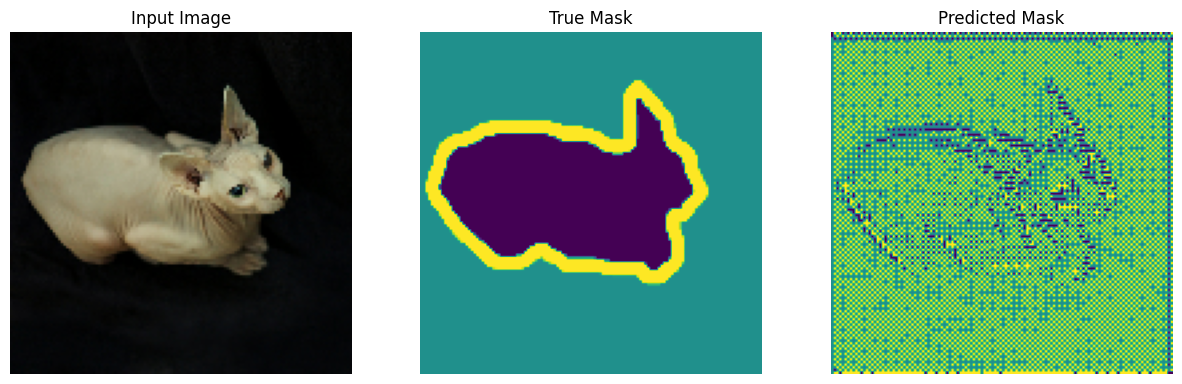

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 67ms/step


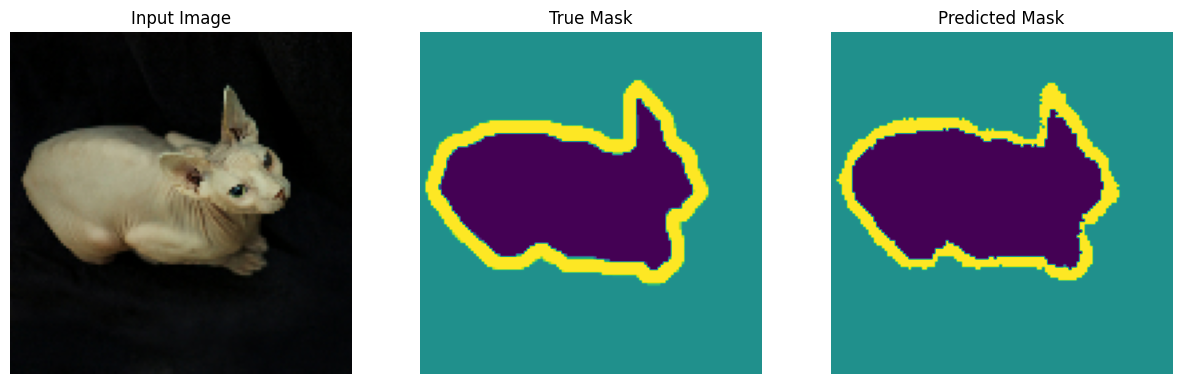


Sample Prediction after epoch 5

57/57 [==============================] - 334s 6s/step - loss: 0.2486 - accuracy: 0.8951 - val_loss: 0.2785 - val_accuracy: 0.8858


In [ ]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

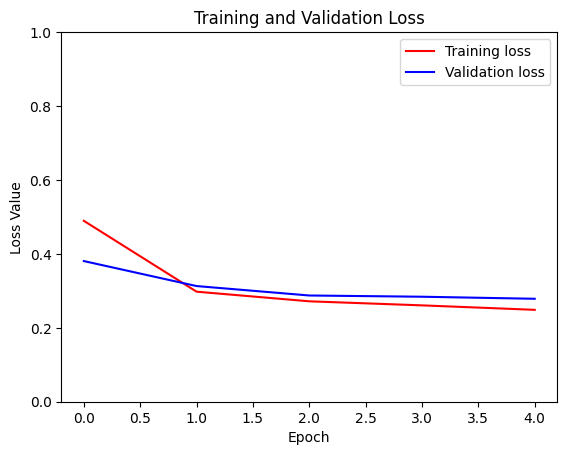

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss', color = 'b')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 [==============================] - 3s 1s/step


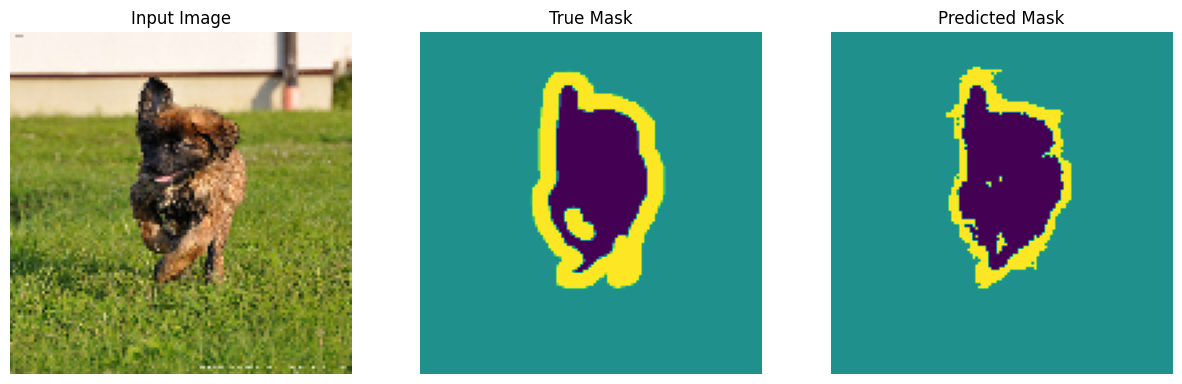

2/2 [==============================] - 3s 1s/step


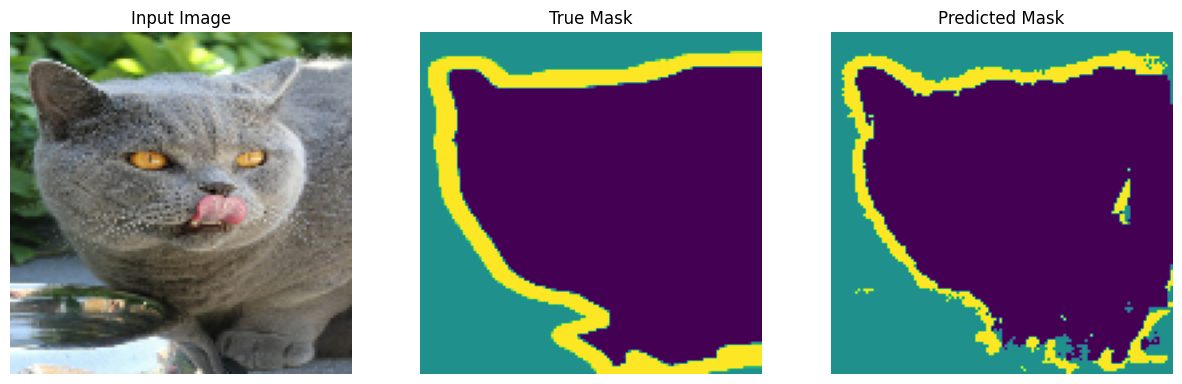

2/2 [==============================] - 2s 1s/step


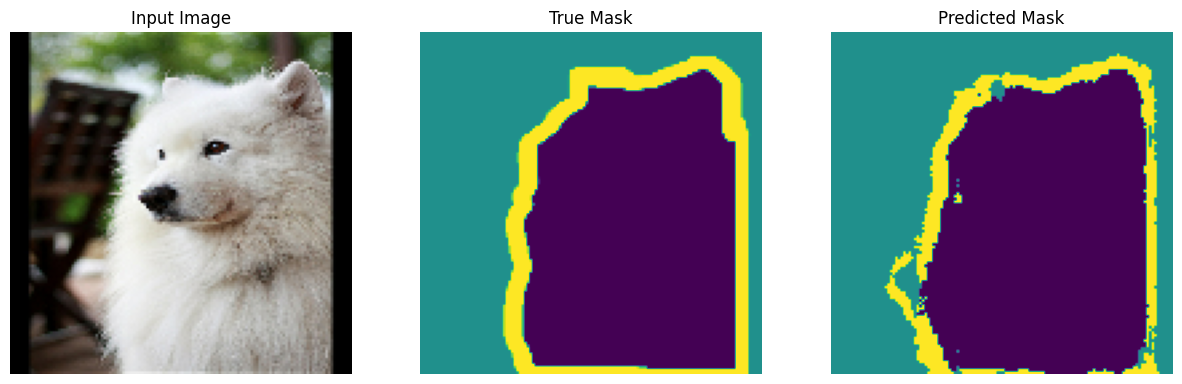

In [ ]:
show_predictions(test_dataset, 3)